In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot
import tensorflow as tf
import pickle
import os

In [2]:
import dataset_utils
from glob import glob

In [3]:
DATA_DIR = "data/entire_field_raw_3_class"
NUM_POINTS = 100
NUM_CLASSES = 3
BATCH_SIZE = 32
train_points, test_points, train_labels, test_labels, CLASS_MAP = dataset_utils.parse_dataset(NUM_POINTS, DATA_DIR)

processing class: walking
processing class: jumping
processing class: speedwalking


In [4]:
print(train_points)

[[[ 1.2285e+00  7.3828e-01 -8.5303e-01  0.0000e+00  2.0700e+02]
  [-2.9810e-01  3.8696e-01  3.3960e-01 -2.5049e-01  2.6000e+02]
  [-2.9810e-01  3.8696e-01  3.3960e-01 -2.5049e-01  2.6000e+02]
  ...
  [ 3.6133e-01 -3.2812e-01  6.1719e-01 -1.2524e-01  3.1300e+02]
  [ 1.2285e+00  7.3828e-01 -8.5303e-01  0.0000e+00  2.0700e+02]
  [ 3.0975e-02  2.9043e+00 -1.9902e+00  0.0000e+00  2.0100e+02]]

 [[-7.6953e-01 -1.0742e+00  7.9443e-01  0.0000e+00  2.3200e+02]
  [-2.3828e+00 -1.6484e+00 -1.2422e+00 -2.5049e-01  2.2800e+02]
  [ 4.0332e-01  3.9697e-01  5.8789e-01 -5.0098e-01  2.0600e+02]
  ...
  [-1.0605e+00 -1.1270e+00  1.5918e+00  1.2524e-01  3.0700e+02]
  [-3.9764e-02 -1.3545e+00  3.1421e-01 -3.7573e-01  1.7900e+02]
  [ 1.0801e+00  7.7930e-01  3.5474e-01  1.2524e-01  3.0600e+02]]

 [[-8.4668e-01 -3.4473e-01 -8.1201e-01 -1.2524e-01  2.6600e+02]
  [-2.0642e-01 -6.8652e-01 -1.0419e-01  1.2524e-01  2.9900e+02]
  [-5.1697e-02 -1.6553e+00  2.9150e-01 -6.2598e-01  3.2400e+02]
  ...
  [ 5.2148e-01  3.

In [5]:
print(test_points)

[[[-5.8838e-01  1.8086e+00 -1.2402e+00 -1.2524e-01  2.3300e+02]
  [-6.7676e-01  1.2305e+00 -6.7188e-01 -2.5049e-01  3.1000e+02]
  [-8.9648e-01  9.5264e-01 -1.0244e+00 -2.5049e-01  3.1000e+02]
  ...
  [-7.1826e-01 -8.5596e-01  1.4189e+00 -2.5049e-01  2.6700e+02]
  [ 5.0684e-01 -1.3223e+00  3.0249e-01 -3.7573e-01  3.0200e+02]
  [-6.7676e-01  1.2305e+00 -6.7188e-01 -2.5049e-01  3.1000e+02]]

 [[-3.0811e-01 -5.1709e-01  8.6865e-01 -1.0020e+00  2.6000e+02]
  [-7.1826e-01 -8.5596e-01  1.4189e+00 -2.5049e-01  2.6700e+02]
  [-7.7051e-01 -1.0781e+00  1.5100e-01 -3.7573e-01  2.8100e+02]
  ...
  [-1.5273e+00 -9.5166e-01 -6.5088e-01 -3.7573e-01  2.5100e+02]
  [ 1.9668e+00  1.2666e+00 -7.4707e-01 -2.5049e-01  3.1600e+02]
  [-6.1084e-01  7.4707e-01  4.2480e-01 -5.0098e-01  2.0700e+02]]

 [[-2.2839e-01 -7.5586e-01 -1.7129e+00 -5.0098e-01  2.1000e+02]
  [-5.3271e-01 -2.0569e-01  8.1299e-01 -2.5049e-01  3.2900e+02]
  [-2.8540e-01  1.1006e+00  3.6987e-01 -2.5049e-01  2.1600e+02]
  ...
  [ 8.5254e-01 -2.

In [6]:
# train_points = train_points[:, :, :3]
# test_points = test_points[:, :, :3]
print(CLASS_MAP)

{0: 'walking', 1: 'jumping', 2: 'speedwalking'}


In [7]:
print(train_points)

[[[ 1.2285e+00  7.3828e-01 -8.5303e-01  0.0000e+00  2.0700e+02]
  [-2.9810e-01  3.8696e-01  3.3960e-01 -2.5049e-01  2.6000e+02]
  [-2.9810e-01  3.8696e-01  3.3960e-01 -2.5049e-01  2.6000e+02]
  ...
  [ 3.6133e-01 -3.2812e-01  6.1719e-01 -1.2524e-01  3.1300e+02]
  [ 1.2285e+00  7.3828e-01 -8.5303e-01  0.0000e+00  2.0700e+02]
  [ 3.0975e-02  2.9043e+00 -1.9902e+00  0.0000e+00  2.0100e+02]]

 [[-7.6953e-01 -1.0742e+00  7.9443e-01  0.0000e+00  2.3200e+02]
  [-2.3828e+00 -1.6484e+00 -1.2422e+00 -2.5049e-01  2.2800e+02]
  [ 4.0332e-01  3.9697e-01  5.8789e-01 -5.0098e-01  2.0600e+02]
  ...
  [-1.0605e+00 -1.1270e+00  1.5918e+00  1.2524e-01  3.0700e+02]
  [-3.9764e-02 -1.3545e+00  3.1421e-01 -3.7573e-01  1.7900e+02]
  [ 1.0801e+00  7.7930e-01  3.5474e-01  1.2524e-01  3.0600e+02]]

 [[-8.4668e-01 -3.4473e-01 -8.1201e-01 -1.2524e-01  2.6600e+02]
  [-2.0642e-01 -6.8652e-01 -1.0419e-01  1.2524e-01  2.9900e+02]
  [-5.1697e-02 -1.6553e+00  2.9150e-01 -6.2598e-01  3.2400e+02]
  ...
  [ 5.2148e-01  3.

In [8]:
from tensorflow import data as tf_data
import keras
import PointNET

keras.utils.set_random_seed(seed=42)

In [9]:
train_size = 0.8
dataset = tf_data.Dataset.from_tensor_slices((train_points, train_labels))
test_dataset = tf_data.Dataset.from_tensor_slices((test_points, test_labels))
train_dataset_size = int(len(dataset) * train_size)

dataset = dataset.shuffle(len(train_points)).map(PointNET.augment)
test_dataset = test_dataset.shuffle(len(test_points)).batch(BATCH_SIZE)

train_dataset = dataset.take(train_dataset_size).batch(BATCH_SIZE)
validation_dataset = dataset.skip(train_dataset_size).batch(BATCH_SIZE)

In [10]:
import keras
import tensorflow as tf
from keras import ops
from keras import layers
from PointNET import tnet, conv_bn, dense_bn

In [11]:
inputs = keras.Input(shape=(NUM_POINTS, 5))

x = tnet(inputs, 5)
x = conv_bn(x, 32)
x = conv_bn(x, 32)
x = tnet(x, 32)
x = conv_bn(x, 32)
x = conv_bn(x, 64)
x = conv_bn(x, 512)
x = layers.GlobalMaxPooling1D()(x)
x = dense_bn(x, 256)
x = layers.Dropout(0.3)(x)
x = dense_bn(x, 128)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
model.summary()

Model: "pointnet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100, 5)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 100, 32)   │        192 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 100, 32)   │        128 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 100, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 100, 64)   │      2,112 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 64)   │        256 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 100, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 100, 512)  │     33,280 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 512)  │      2,048 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 100, 512)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ activation_2[0][… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    131,328 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 256)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     32,896 │ activation_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 128)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 25)        │      3,225 │ activation_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 5, 5)      │          0 │ dense_2[0][0]   

 Total params: 750,268 (2.86 MB)

 Trainable params: 744,188 (2.84 MB)

 Non-trainable params: 6,080 (23.75 KB)

In [12]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)

model.fit(train_dataset, epochs=20, validation_data=validation_dataset)

Epoch 1/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - loss: 59.3423 - sparse_categorical_accuracy: 0.4443 - val_loss: 38.7000 - val_sparse_categorical_accuracy: 0.6354
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 37.9701 - sparse_categorical_accuracy: 0.7208 - val_loss: 37.0143 - val_sparse_categorical_accuracy: 0.7604
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 37.0443 - sparse_categorical_accuracy: 0.7570 - val_loss: 38.2569 - val_sparse_categorical_accuracy: 0.7083
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 37.0538 - sparse_categorical_accuracy: 0.7806 - val_loss: 36.9207 - val_sparse_categorical_accuracy: 0.7812
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 36.9010 - sparse_categorical_accuracy: 0.7760 - val_loss: 36.8899 - val_sparse_categorical_accuracy: 0.8438
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 36.8270 - sparse_categorical_accuracy: 0.8166 - val_loss: 37.0135 - val_sparse_categorical_accuracy: 0.760

In [14]:
from matplotlib import pyplot as plt

2024-08-16 17:29:33.211590: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
[[[ 1.0332e+00  1.1123e+00 -2.2500e+00  3.7573e-01  2.1000e+02]
  [ 5.7373e-01  4.9854e-01  3.3057e-01 -7.5146e-01  2.5900e+02]
  [-8.0322e-01 -1.2764e+00  9.5410e-01  1.2524e-01  2.1500e+02]
  ...
  [ 1.3440e-01  5.6787e-01 -7.4268e-01  6.2598e-01  2.1000e+02]
  [ 5.1758e-01 -3.3252e-01 -1.1094e+00 -8.7646e-01  2.1600e+02]
  [-1.2764e+00 -4.1473e-02  3.9990e-01 -7.5146e-01  4.2800e+02]]

 [[-8.7695e-01  6.3623e-01  1.1646e-01  2.5049e-01  3.8700e+02]
  [-2.8540e-01  3.1519e-01 -6.5552e-02  6.2598e-01  2.1800e+02]
  [ 7.0703e-01 -1.0938e+00  7.4658e-01  2.5049e-01  3.4700e+02]
  ...
  [ 8.7793e-01  1.2070e+00  8.4033e-01 -6.2598e-01  3.2500e+02]
  [ 1.1367e+00  9.7754e-01 -5.7520e-01 -5.0098e-01  3.0800e+02]
  [-1.5283e-01  5.6152e-01 -5.9717e-01  6.2598e-01  2.9200e+02]]

 [[ 1.9119e-02 -9.9854e-01  6.5332e-01  1.2524e-01  2.3100e+02]
  [-1.1074e+00  5.3564e-01  1.3867e+00 -7.5146e-01  3.3200e+02]
  [-1.2734e+00  1.3262e+00 -1.8567e-01 -6.2598e-0

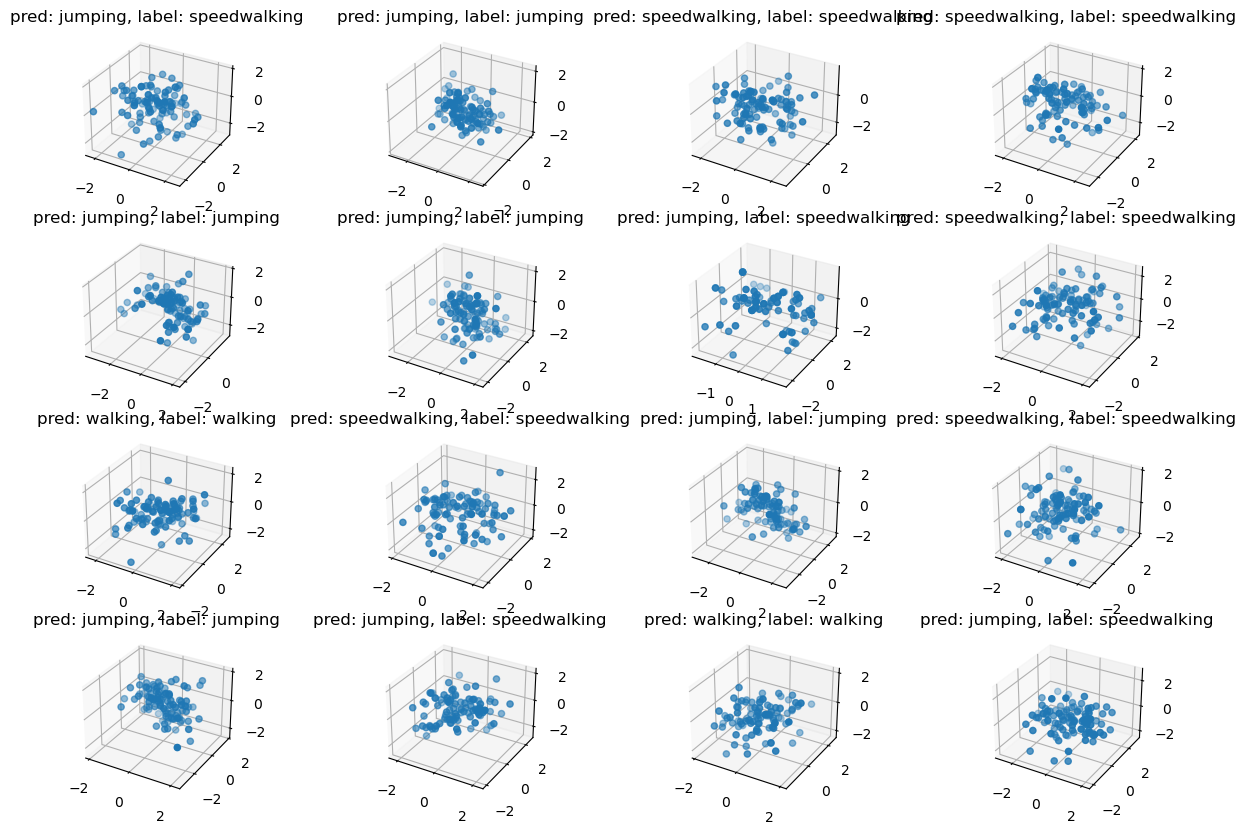

In [15]:
data = test_dataset.take(1)

points, labels = list(data)[0]
points = points[:20, ...]
labels = labels[:20, ...]

# run test data through model
preds = model.predict(points)
preds = ops.argmax(preds, -1)

points = points.numpy()
print(points)

# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred: {:}, label: {:}".format(
            CLASS_MAP[preds[i].numpy()], CLASS_MAP[labels.numpy()[i]]
        )
    )
    ax.set_axis_on()
plt.show()

In [16]:
predictions = []

# Calculate the number of sections, ensure it's at least 1
num_sections = max(1, len(test_points) // NUM_POINTS)

for batch in np.array_split(test_points, num_sections): 
    preds = model.predict(batch)
    preds = np.argmax(preds, axis=-1)
    predictions.extend(preds)

predictions = np.array(predictions)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step 


In [17]:
accuracy = np.sum(predictions == test_labels) / len(test_labels)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 82.50%


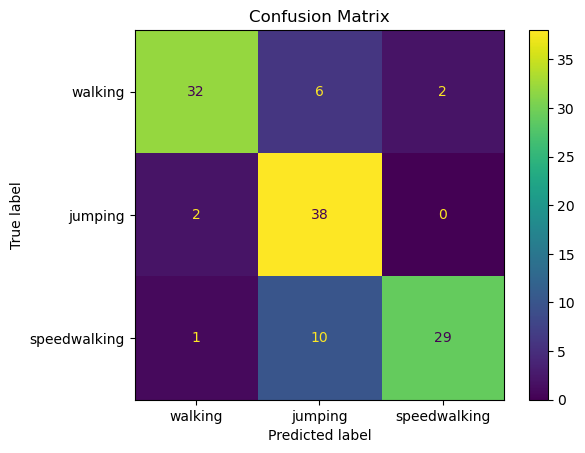

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Plotting the confusion matrix
# Compute the confusion matrix
cm = confusion_matrix(test_labels, predictions)

# Plotting the confusion matrix
class_names = ['walking', 'jumping', 'speedwalking']  # Based on your CLASS_MAP
disp = ConfusionMatrixDisplay(cm, display_labels=class_names)

# Display the plot
disp.plot()
plt.title("Confusion Matrix")
plt.show()


In [18]:
model.save('pointnet_sd_3_class_data_5_dims.h5', save_format='h5')
# model.get_config()

NotImplementedError: <PointNET.OrthogonalRegularizer object at 0x3108f52d0> does not implement get_config()